## VAE

### Functions

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),]) # Converting images to tensor

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [5]:
torch.manual_seed(42)
np.random.seed(42)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim,input_dim,hidden_dim1,hidden_dim2):
        super(VAE, self).__init__()
        self.input_dim=input_dim
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mean = nn.Linear(hidden_dim2, latent_dim)
        self.fc_variance = nn.Linear(hidden_dim2, latent_dim) 
        
        # Decoder
        self.fc4 = nn.Linear(latent_dim, hidden_dim2)
        self.fc5 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc6 = nn.Linear(hidden_dim1, input_dim)
        
    def encode(self, x):
        hidden_out1 = F.relu(self.fc1(x))
        hidden_out2 = F.relu(self.fc2(hidden_out1))
        return self.fc_mean(hidden_out2), self.fc_variance(hidden_out2)  # Returns mean, log_var
    
    def reparameterize(self, mean, log_var):
        standard_deviation = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(standard_deviation) # ϵ∼N(0,1) (random noise)
        z = mean + epsilon * standard_deviation
        return z
    
    def decode(self, z):
        hidden_out3 = F.relu(self.fc4(z))
        hidden_out4 = F.relu(self.fc5(hidden_out3))
        return torch.sigmoid(self.fc6(hidden_out4))  # Outputs between 0 and 1 for MNIST
    
    def forward(self, x):
        mu, log_variance = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, log_variance)
        return self.decode(z), mu, log_variance

In [7]:
def bce_loss_function(reconstructed_x, x,input_dim):
    bce = F.binary_cross_entropy(reconstructed_x, x.view(-1, input_dim), reduction='sum')
    return bce

def mse_loss_function(reconstructed_x, x,input_dim):
    mse = F.mse_loss(reconstructed_x, x.view(-1, input_dim), reduction='sum')
    return mse
    
def KL_divergence_loss(mu, log_var):
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return kl_div

### Reconstruction Loss=BCE Loss without KL

In [56]:
latent_dim=2
input_dim=28*28
hidden_dim1=512
hidden_dim2=256
epochs=10
model = VAE(latent_dim,input_dim,hidden_dim1,hidden_dim2).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [57]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_dataloader:
        x_train,y_train=batch
        optimizer.zero_grad()
        reconstructed_batch, mu, log_var = model(x_train.to('cuda'))
        bce_loss= bce_loss_function(reconstructed_batch,x_train.to('cuda'),input_dim)
        
        bce_loss.backward()
        train_loss += bce_loss.item()
        optimizer.step()
    
    if epoch%1==0:
        print(f'Epoch: {epoch} Average loss: {train_loss / len(train_dataloader):.4f}')

Epoch: 0 Average loss: 10513.3708
Epoch: 1 Average loss: 9710.6499
Epoch: 2 Average loss: 9564.3122
Epoch: 3 Average loss: 9500.0712
Epoch: 4 Average loss: 9446.2065
Epoch: 5 Average loss: 9360.5076
Epoch: 6 Average loss: 9325.8287
Epoch: 7 Average loss: 9299.6589
Epoch: 8 Average loss: 9284.5686
Epoch: 9 Average loss: 9218.2321


In [58]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        x_test,y_test=batch
        reconstructed_batch_test, mu_test, log_var_test = model(x_test.to('cuda'))
        
        loss = bce_loss_function(reconstructed_batch_test,x_test.to('cuda'),input_dim)
        test_loss += loss.item()

print(f"Average Test loss: {test_loss/len(test_dataloader):.4f}")

Average Test loss: 9237.9883


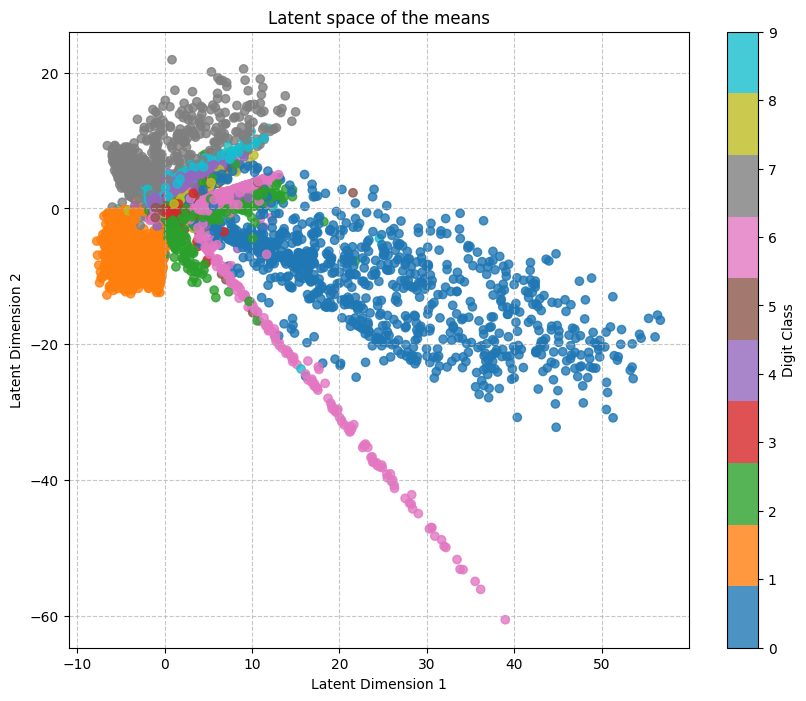

In [59]:
model.eval()
means = []
labels = []

with torch.no_grad():
    batch_idx=0
    for batch in test_dataloader:
        batch_idx=batch_idx+1
        x_test,y_test=batch
        reconstructed_batch, mu, log_var = model(x_test.to('cuda'))
        means.append(mu.cpu().numpy())
        labels.append(y_test.numpy())
        
        # # Limit samples for visualization clarity
        # if batch_idx >= 20:  # Approximately 20 * batch_size samples
        #     break

means = np.vstack(means)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, label='Digit Class')
plt.title('Latent space of the means')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

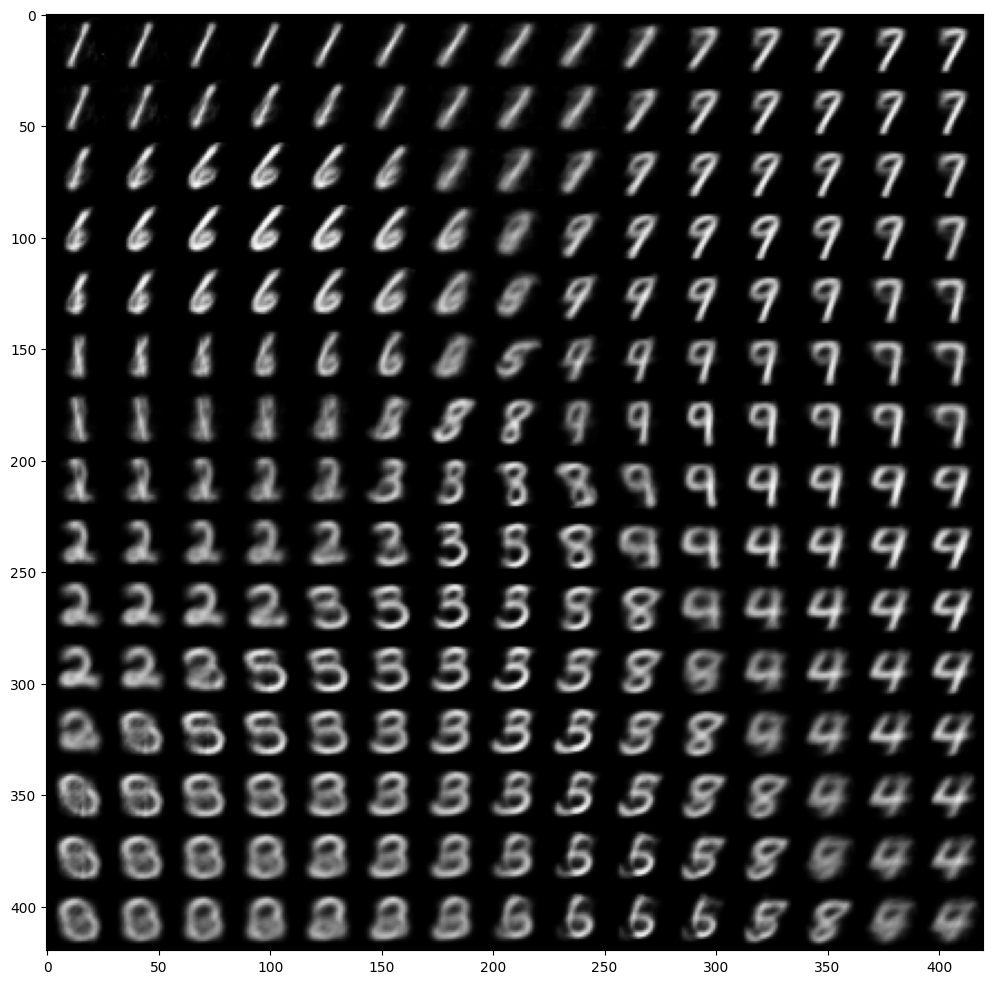

In [60]:

grid_size=15
model.eval()
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)

figure = np.zeros((grid_size * 28, grid_size * 28))

with torch.no_grad():
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to('cuda')
            decoded = model.decode(z)
            digit = decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.tight_layout()
plt.show()

### Reconstruction Loss=BCE Loss with KL

In [29]:
latent_dim=2
input_dim=28*28
hidden_dim1=512
hidden_dim2=256
epochs=20
model = VAE(latent_dim,input_dim,hidden_dim1,hidden_dim2).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [30]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_dataloader:
        x_train,y_train=batch
        optimizer.zero_grad()
        reconstructed_batch, mu, log_var = model(x_train.to('cuda'))
        bce_loss= bce_loss_function(reconstructed_batch,x_train.to('cuda'),input_dim)
        kl_loss= KL_divergence_loss(mu,log_var)
        loss=bce_loss+kl_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    if epoch%1==0:
        print(f'Epoch: {epoch} Average loss: {train_loss / len(train_dataloader):.4f}')

Epoch: 0 Average loss: 10632.2545
Epoch: 1 Average loss: 10019.0490
Epoch: 2 Average loss: 9892.1305
Epoch: 3 Average loss: 9811.5030
Epoch: 4 Average loss: 9772.4109
Epoch: 5 Average loss: 9802.5292
Epoch: 6 Average loss: 9694.4624
Epoch: 7 Average loss: 9701.4138
Epoch: 8 Average loss: 9892.2310
Epoch: 9 Average loss: 9714.2943
Epoch: 10 Average loss: 9641.7836
Epoch: 11 Average loss: 9659.7803
Epoch: 12 Average loss: 9676.1273
Epoch: 13 Average loss: 9600.6214
Epoch: 14 Average loss: 9591.5773
Epoch: 15 Average loss: 9595.7913
Epoch: 16 Average loss: 9591.7042
Epoch: 17 Average loss: 9687.9367
Epoch: 18 Average loss: 9717.7931
Epoch: 19 Average loss: 9618.6664


In [31]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        x_test,y_test=batch
        reconstructed_batch_test, mu_test, log_var_test = model(x_test.to('cuda'))
        
        bce_loss= bce_loss_function(reconstructed_batch,x_train.to('cuda'),input_dim)
        kl_loss= KL_divergence_loss(mu,log_var)
        loss=bce_loss+kl_loss
        test_loss += loss.item()

print(f"Average Test loss: {test_loss/len(test_dataloader):.4f}")

Average Test loss: 4922.8208


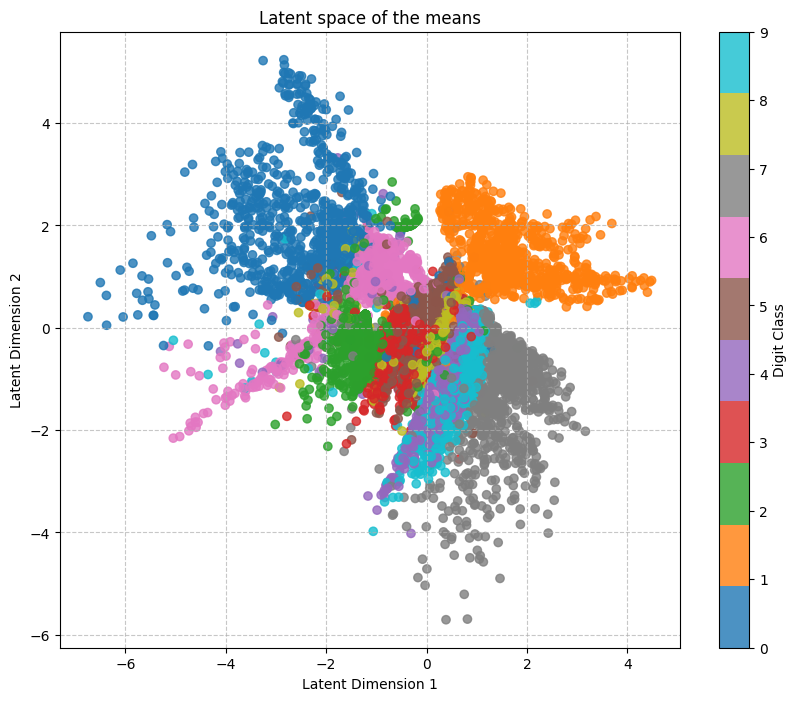

In [32]:
model.eval()
means = []
labels = []

with torch.no_grad():
    batch_idx=0
    for batch in test_dataloader:
        batch_idx=batch_idx+1
        x_test,y_test=batch
        reconstructed_batch, mu, log_var = model(x_test.to('cuda'))
        means.append(mu.cpu().numpy())
        labels.append(y_test.numpy())
        
        # # Limit samples for visualization clarity
        # if batch_idx >= 20:  # Approximately 20 * batch_size samples
        #     break

means = np.vstack(means)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, label='Digit Class')
plt.title('Latent space of the means')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

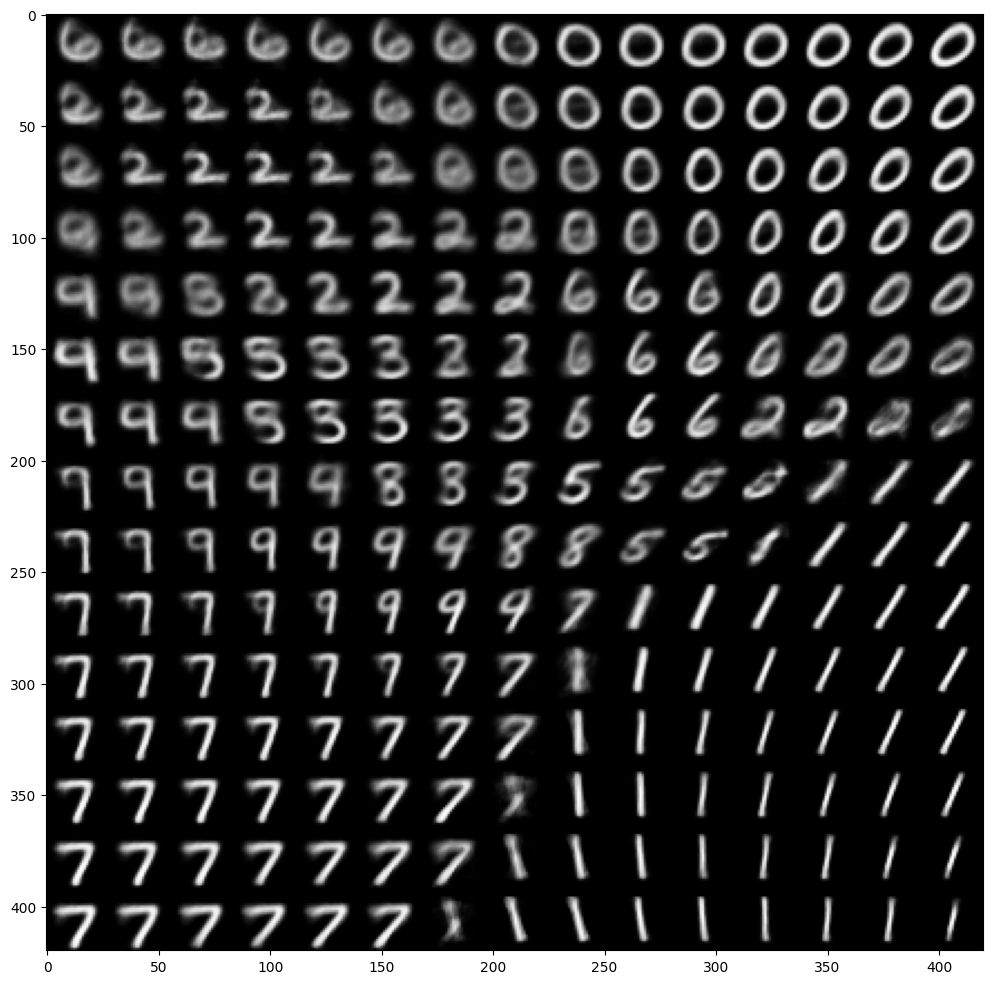

In [33]:
grid_size=15
model.eval()
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)

figure = np.zeros((grid_size * 28, grid_size * 28))

with torch.no_grad():
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to('cuda')
            decoded = model.decode(z)
            digit = decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.tight_layout()
plt.show()

### KL Loss without Reconstruction Loss

In [146]:
latent_dim=2
input_dim=28*28
hidden_dim1=512
hidden_dim2=256
epochs=3
model = VAE(latent_dim,input_dim,hidden_dim1,hidden_dim2).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [147]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_dataloader:
        x_train,y_train=batch
        optimizer.zero_grad()
        reconstructed_batch, mu, log_var = model(x_train.to('cuda'))
        kl_loss= KL_divergence_loss(mu,log_var)
        loss=kl_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    if epoch%1==0:
        print(f'Epoch: {epoch} Average loss: {train_loss / len(train_dataloader):.4f}')

Epoch: 0 Average loss: 16.7002
Epoch: 1 Average loss: 0.0029
Epoch: 2 Average loss: 0.0016


In [148]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        x_test,y_test=batch
        reconstructed_batch_test, mu_test, log_var_test = model(x_test.to('cuda'))
        
        kl_loss= KL_divergence_loss(mu,log_var)
        loss=kl_loss
        test_loss += loss.item()

print(f"Average Test loss: {test_loss/len(test_dataloader):.4f}")

Average Test loss: 0.0001


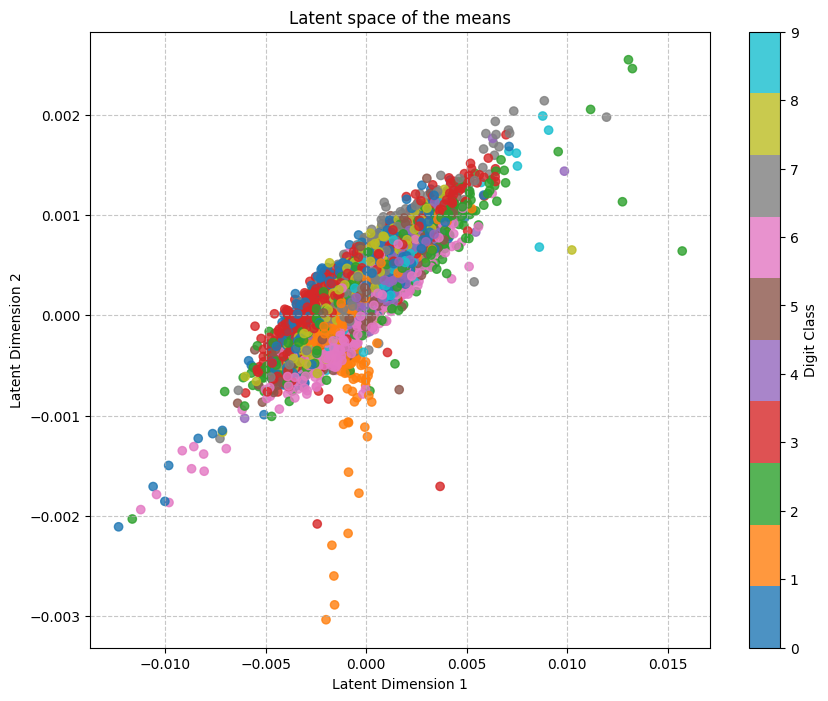

In [149]:
model.eval()
means = []
labels = []

with torch.no_grad():
    batch_idx=0
    for batch in test_dataloader:
        batch_idx=batch_idx+1
        x_test,y_test=batch
        reconstructed_batch, mu, log_var = model(x_test.to('cuda'))
        means.append(mu.cpu().numpy())
        labels.append(y_test.numpy())
        
        # # Limit samples for visualization clarity
        # if batch_idx >= 20:  # Approximately 20 * batch_size samples
        #     break

means = np.vstack(means)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, label='Digit Class')
plt.title('Latent space of the means')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

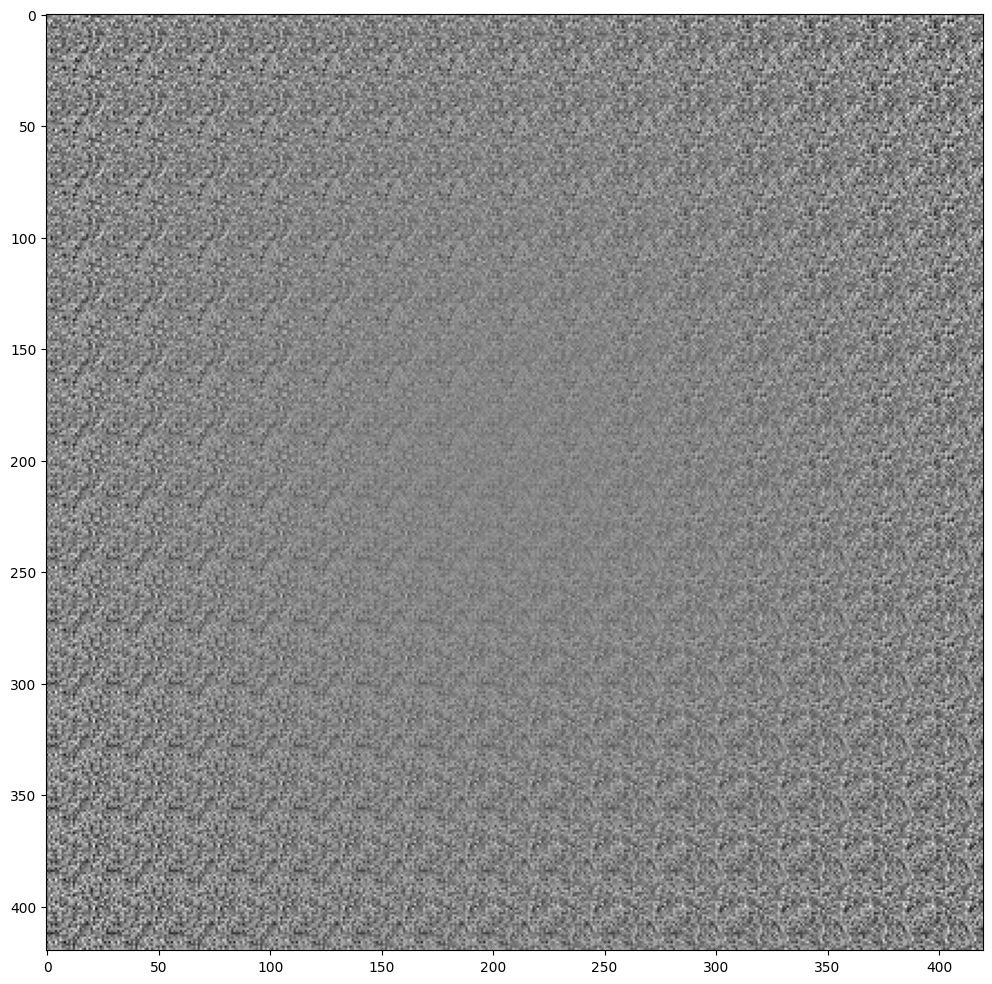

In [150]:

grid_size=15
model.eval()
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)

figure = np.zeros((grid_size * 28, grid_size * 28))

with torch.no_grad():
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to('cuda')
            decoded = model.decode(z)
            digit = decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.tight_layout()
plt.show()

#### Observations - Latent space

The latent space is a continuous representation where each point corresponds to an encoding of an input digit.
Each point represents the mean of the latent distribution 
Different colors indicate different digit classes (0-9).
The two axes correspond to the two-dimensional latent space.

Ideally, similar digits should cluster together, meaning the VAE has learned a structured latent space where digits are organized meaningfully.
Some digits (e.g., orange, corresponding to '1') are well-separated, while others (e.g., digits around the origin) are more mixed.

1. BCE + KL Loss
- The latent space seems to be well-regularized, meaning similar digits are close together and it is well-clustered.
- The KL Divergence loss ensures that the latent space is continuous and normally distributed, preventing overfitting.
- The KL divergence is enforcing a structured, Gaussian-like latent space.

2. Without KL Loss
- The latent space lacks structure, and some transitions are abrupt.
- The model is likely overfitting to specific examples rather than learning a meaningful latent representation.
Without KL loss, the model behaves more like a standard Autoencoder rather than a Variational Autoencoder.

3. Without Reconstruction Loss
- Without reconstruction loss, the VAE essentially becomes just a variational encoder that maps input data to a latent distribution without ensuring this distribution can be meaningfully decoded back to the original data. 
- The reconstruction loss is what forces the latent space to retain information about the input. Without it, there's no incentive for the encoder to preserve distinguishing features of different inputs.
- When visualizing the latent space, you'll likely see that all data points cluster tightly around the origin with no clear structure or separation between different classes or data types.

#### Observations - Reconstructions generated from the VaE

1. Smooth Latent Space Interpolations (KL + BCE):
    - The reconstructions transition smoothly across the latent space.
    - The generated digits blend naturally from one class to another.
    - The structure of the digits is well-preserved.

2. Sharper Reconstructions but Poor Latent Space Coverage (BCE only):
    - The reconstructions appear sharper but may lack smooth transitions.
    - The latent space is not well-organized, potentially leading to erratic outputs when interpolating between points.

3. Blurry and Unstable Reconstructions (KL only):
    - The generated digits appear blurry and sometimes uninterpretable.
    - Without BCE loss enforcing pixel-level accuracy, the outputs may not be faithful to the real data distribution.

### Reconstruction Loss = MSE loss without KL Loss

In [16]:
latent_dim=2
input_dim=28*28
hidden_dim1=512
hidden_dim2=256
epochs=10
model = VAE(latent_dim,input_dim,hidden_dim1,hidden_dim2).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [17]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_dataloader:
        x_train,y_train=batch
        optimizer.zero_grad()
        reconstructed_batch, mu, log_var = model(x_train.to('cuda'))
        mse_loss= mse_loss_function(reconstructed_batch,x_train.to('cuda'),input_dim)
        
        mse_loss.backward()
        train_loss += mse_loss
        optimizer.step()
    
    if epoch%1==0:
        print(f'Epoch: {epoch} Average loss: {train_loss / len(train_dataloader):.4f}')

Epoch: 0 Average loss: 2332.8184
Epoch: 1 Average loss: 2095.1936
Epoch: 2 Average loss: 2042.2974
Epoch: 3 Average loss: 2022.9772
Epoch: 4 Average loss: 2007.6420
Epoch: 5 Average loss: 2027.7539
Epoch: 6 Average loss: 2013.0051
Epoch: 7 Average loss: 2004.2064
Epoch: 8 Average loss: 1986.9194
Epoch: 9 Average loss: 1982.3848


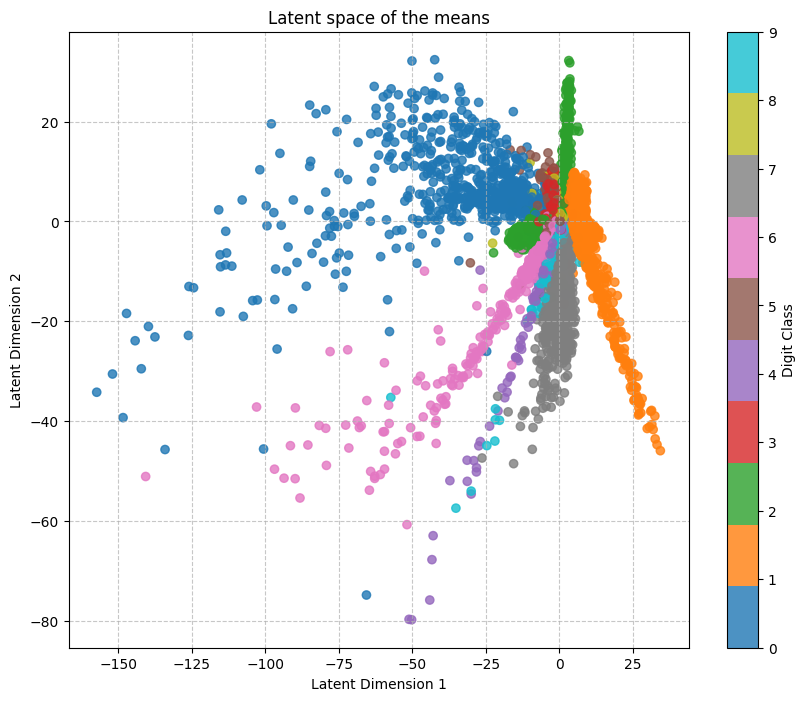

In [ ]:
model.eval()
means = []
labels = []

with torch.no_grad():
    batch_idx=0
    for batch in test_dataloader:
        batch_idx=batch_idx+1
        x_test,y_test=batch
        reconstructed_batch, mu, log_var = model(x_test.to('cuda'))
        means.append(mu.cpu().numpy())
        labels.append(y_test.numpy())
        
        # # Limit samples for visualization clarity
        # if batch_idx >= 20:  # Approximately 20 * batch_size samples
        #     break

means = np.vstack(means)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, label='Digit Class')
plt.title('Latent space of the means')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

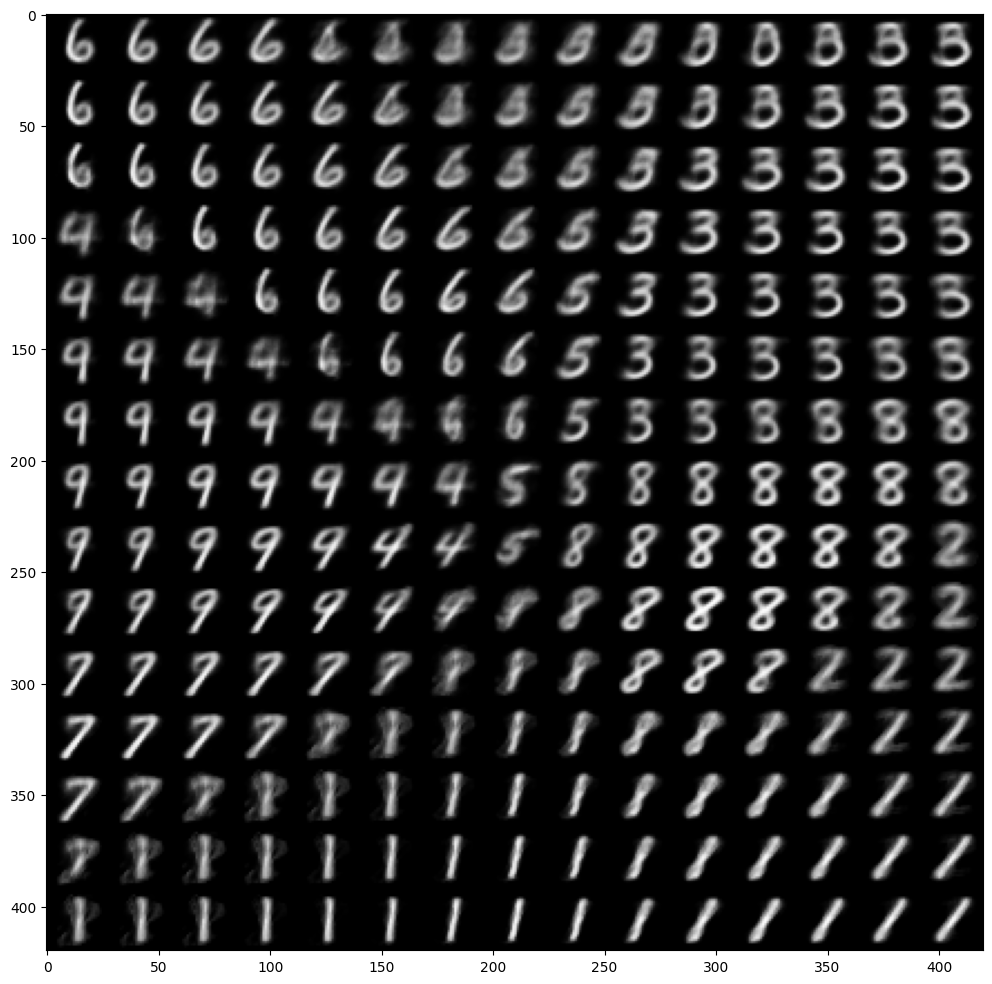

In [ ]:
grid_size=15
model.eval()
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)

figure = np.zeros((grid_size * 28, grid_size * 28))

with torch.no_grad():
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to('cuda')
            decoded = model.decode(z)
            digit = decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.tight_layout()
plt.show()

### Reconstruction Loss = MSE loss with KL Loss

In [8]:
latent_dim=2
input_dim=28*28
hidden_dim1=512
hidden_dim2=256
epochs=10
model = VAE(latent_dim,input_dim,hidden_dim1,hidden_dim2).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [9]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_dataloader:
        x_train,y_train=batch
        optimizer.zero_grad()
        reconstructed_batch, mu, log_var = model(x_train.to('cuda'))
        mse_loss= mse_loss_function(reconstructed_batch,x_train.to('cuda'),input_dim)
        kl_loss=KL_divergence_loss(mu,log_var)
        loss=kl_loss+mse_loss
        loss.backward()
        train_loss += loss
        optimizer.step()
    
    if epoch%1==0:
        print(f'Epoch: {epoch} Average loss: {train_loss / len(train_dataloader):.4f}')

Epoch: 0 Average loss: 2785.9607
Epoch: 1 Average loss: 2603.2183
Epoch: 2 Average loss: 2562.8396
Epoch: 3 Average loss: 2561.8901
Epoch: 4 Average loss: 2548.9138
Epoch: 5 Average loss: 2545.9419
Epoch: 6 Average loss: 2560.6523
Epoch: 7 Average loss: 2536.7051
Epoch: 8 Average loss: 2525.0991
Epoch: 9 Average loss: 2552.1711


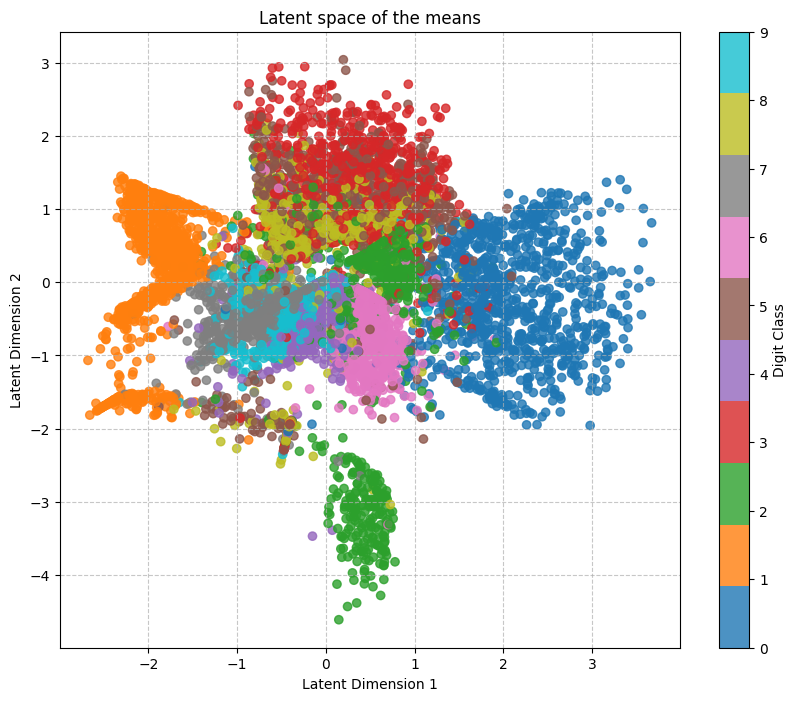

In [10]:
model.eval()
means = []
labels = []

with torch.no_grad():
    batch_idx=0
    for batch in test_dataloader:
        batch_idx=batch_idx+1
        x_test,y_test=batch
        reconstructed_batch, mu, log_var = model(x_test.to('cuda'))
        means.append(mu.cpu().numpy())
        labels.append(y_test.numpy())
        
        # # Limit samples for visualization clarity
        # if batch_idx >= 20:  # Approximately 20 * batch_size samples
        #     break

means = np.vstack(means)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, label='Digit Class')
plt.title('Latent space of the means')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

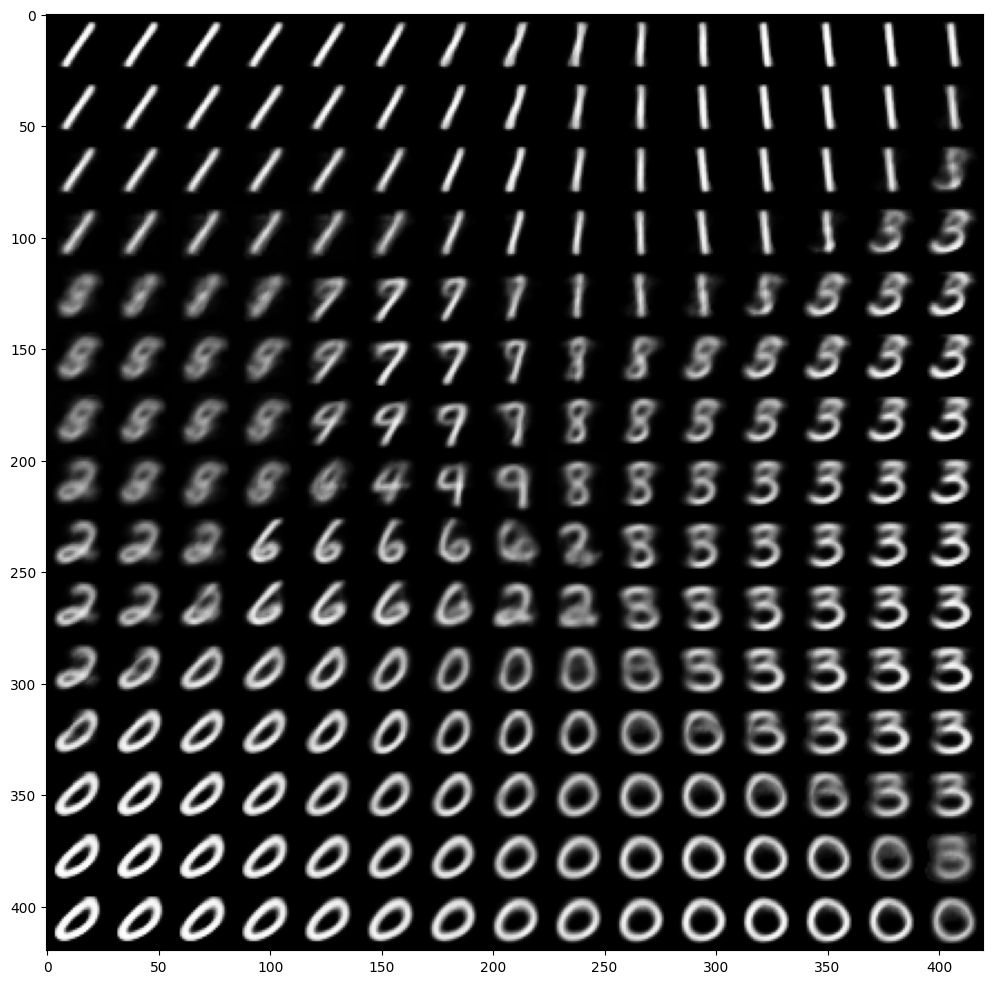

In [11]:
grid_size=15
model.eval()
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)

figure = np.zeros((grid_size * 28, grid_size * 28))

with torch.no_grad():
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to('cuda')
            decoded = model.decode(z)
            digit = decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.tight_layout()
plt.show()

### KL loss without Reconstruction Loss =MSE

In [12]:
latent_dim=2
input_dim=28*28
hidden_dim1=512
hidden_dim2=256
epochs=10
model = VAE(latent_dim,input_dim,hidden_dim1,hidden_dim2).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [13]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch in train_dataloader:
        x_train,y_train=batch
        optimizer.zero_grad()
        reconstructed_batch, mu, log_var = model(x_train.to('cuda'))
        kl_loss= KL_divergence_loss(mu,log_var)        
        kl_loss.backward()
        train_loss += kl_loss
        optimizer.step()
    
    if epoch%1==0:
        print(f'Epoch: {epoch} Average loss: {train_loss / len(train_dataloader):.4f}')

Epoch: 0 Average loss: 31.4223
Epoch: 1 Average loss: 0.0271
Epoch: 2 Average loss: 0.0196
Epoch: 3 Average loss: 0.0205
Epoch: 4 Average loss: 0.0019
Epoch: 5 Average loss: 0.0050
Epoch: 6 Average loss: 0.0022
Epoch: 7 Average loss: 0.0001
Epoch: 8 Average loss: 0.0008
Epoch: 9 Average loss: 0.0005


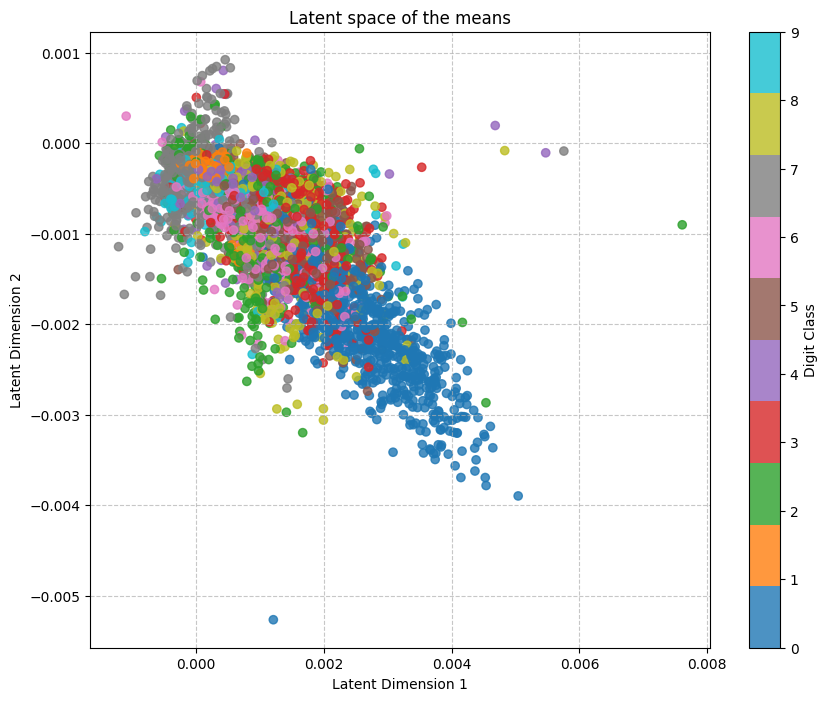

In [14]:
model.eval()
means = []
labels = []

with torch.no_grad():
    batch_idx=0
    for batch in test_dataloader:
        batch_idx=batch_idx+1
        x_test,y_test=batch
        reconstructed_batch, mu, log_var = model(x_test.to('cuda'))
        means.append(mu.cpu().numpy())
        labels.append(y_test.numpy())
        
        # # Limit samples for visualization clarity
        # if batch_idx >= 20:  # Approximately 20 * batch_size samples
        #     break

means = np.vstack(means)
labels = np.concatenate(labels)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(means[:, 0], means[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.colorbar(scatter, label='Digit Class')
plt.title('Latent space of the means')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.close()

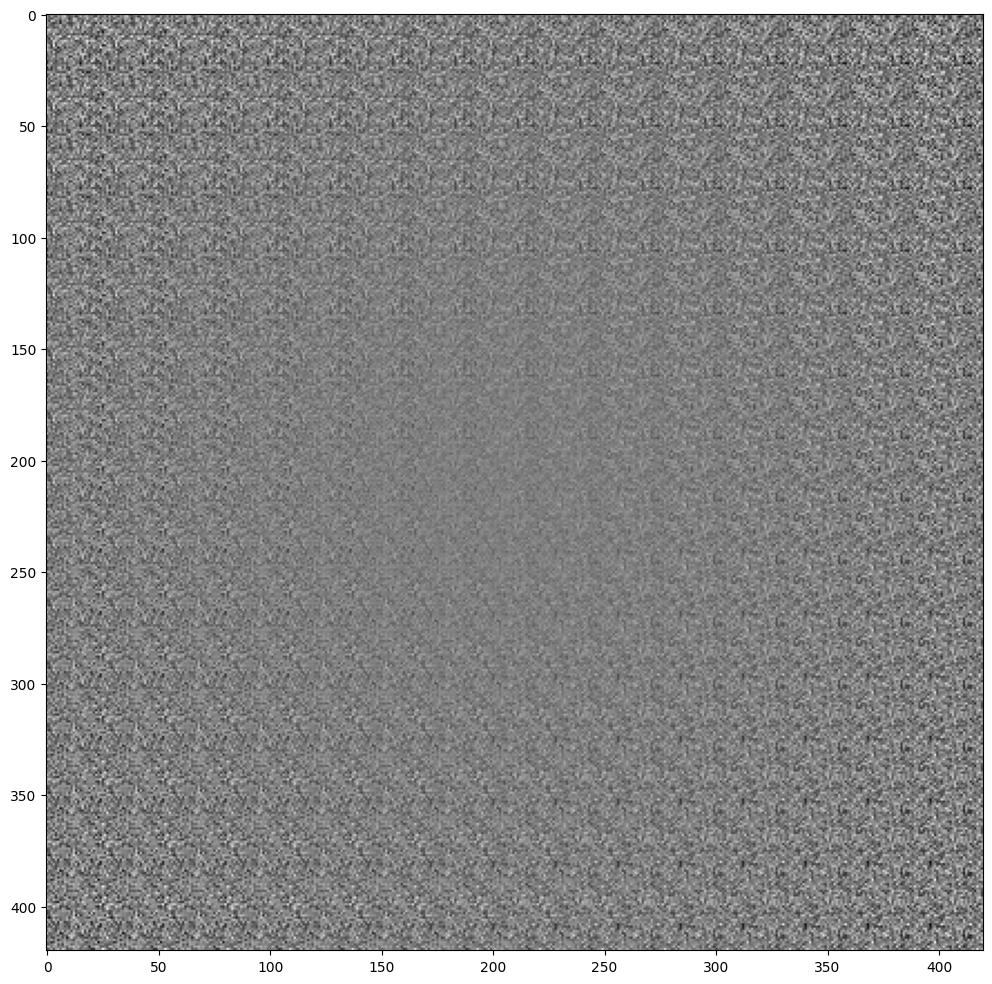

In [15]:
grid_size=15
model.eval()
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)

figure = np.zeros((grid_size * 28, grid_size * 28))

with torch.no_grad():
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            z = torch.tensor([[xi, yi]], dtype=torch.float).to('cuda')
            decoded = model.decode(z)
            digit = decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.tight_layout()
plt.show()

#### Observations - Difference between MSE and BCE loss

1. Effect on Reconstruction Quality:
MSE produces blurry reconstructionsa as compared to BCE, as BCE treats pixel values as probabilities (good for binary images), whereas MSE directly measures pixel-wise differences.
2. MSE encourages averaging, leading to smoother, blurrier images since it penalizes large deviations more than small ones.
3. BCE is derived from a probabilistic perspective, it pushes pixel values toward either 0 or 1, maintaining clearer edges and finer details.
4. MSE can lead to a less structured latent space MSE may struggle to enforce good separation between different clusters (digit classes in MNIST)